### Based on the paper from Goodwill et al.

In [91]:
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from src.data.ctable import cache_cts, CTableStore, ctable_mv
from src.data.smote import smote
from src.tools.cache import NBCache
from src.tools.object import get_custom_attributes
from src.tools.plotter import line_plot
from src.tools.traceloader import ASCAD
from src.tvla.chi2 import chi2
from src.tvla.t import make_t_test
from src.tvla.main import tvla

sns.set_style("whitegrid")

In [92]:
SMOTE_LEVEL = 500
cache = NBCache("tvla/t_test", version=f"smote_{SMOTE_LEVEL}")

## Application of TVLA on ASCAD

In [93]:
ascad = ASCAD()

### Create contingency tables from traces.

In [94]:
ct_default = cache_cts(cache, "ascad_default", ascad.default.profile, SMOTE_LEVEL)
ct_random = cache_cts(cache, "ascad_random", ascad.random.profile, SMOTE_LEVEL)
ct_mask = cache_cts(cache, "ascad_mask", ascad.masked.profile, SMOTE_LEVEL)

### Retrieve mean and variance from contingency tables.

In [95]:
def get_num_observations(f: h5py.File):
    return f["key_000"]["cat_0"]["slice_0"][0].sum()

def get_trace_len(f: h5py.File):
    return len(f["key_000"]["cat_0"]["slice_0"])

def get_mv(f: h5py.File):
    num_obs = get_num_observations(f)
    slice_len = get_trace_len(f)

    def convert(sample_pts: np.array):
        arr = np.array([np.zeros(2, dtype=np.float128)] * slice_len)
        for sp, sample_pt in enumerate(sample_pts):
            arr[sp] = np.array(ctable_mv(sample_pt, num_obs))

        return arr

    return np.array(
        [np.array(
            [np.array(
                [convert(f[k][c][s]) for s in f[k][c]])
            for c in f[k]])
        for k in tqdm(f, "Retrieving mean and variance")])

mv_default = cache.np("mv_default")
mv_random = cache.np("mv_random")
mv_masked = cache.np("mv_masked")

In [96]:
len(ct_default["key_000"]["cat_0"]["slice_0"])

1400

In [97]:
# Number of observations does not vary on the SMOTEd data.
obs_default = get_num_observations(ct_default)
obs_mask = get_num_observations(ct_mask)
obs_random = get_num_observations(ct_random)

[Text(0.5, 1.0, 'Mean and variance of first key, category and slice.\n')]

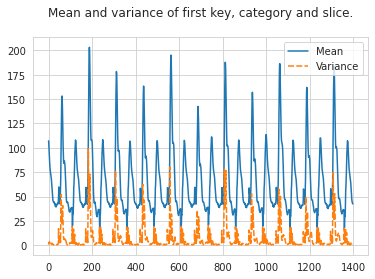

In [98]:
g = sns.lineplot(data=pd.DataFrame(mv_default[0][0][0], columns=["Mean", "Variance"]))
g.set(title="Mean and variance of first key, category and slice.\n")

In [99]:
def make_left_right(stat_moments):
    def get_left(k):
        return stat_moments[k][1][0]

    def get_right(k):
        return stat_moments[k][1][1]

    return get_left, get_right

def get_diff(stat_moments, key_range=range(256)):
    left, right = make_left_right(stat_moments)

    kr = key_range

    dist_neq = [abs(left(i) - right(j)) for i in kr for j in kr if i != j]
    dist_eq = [abs(left(i) - right(i)) for i in kr]

    return np.mean(dist_neq, axis=0) - np.mean(dist_eq, axis=0)

def plot_highest_diff(mvs, heat, title):
    key_selected = get_max_index(heat)

    mv_diff = pd.DataFrame({"Mean": np.moveaxis(get_diff(mvs, key_selected), 0, -1)[0]})
    line_plot(mv_diff, title=title)
    line_plot(mv_diff, xlim=POI, title=f"{title} at PoI {POI}")

### Investigate dataset.

In [100]:
POI = 59, 85
# POI = 800, 830

def get_num_moments(stat_moments):
    return len(stat_moments[0][0][0][0])

def get_heatmap(stat_moments):
    num_moments = get_num_moments(stat_moments)
    num_keys = len(stat_moments)

    res = np.zeros((num_keys, num_keys, num_moments), dtype=np.float128)
    for i in tqdm(range(num_keys)):
        for j in range(num_keys):
            if i == j:
                res[i][j] = np.array([0] * num_moments)
            else:
                diff = get_diff(mv_default, [i, j])
                diff[np.less(diff, 0)] = 0
                # Difference ratio over the rest of the trace
                res[i][j] = diff[POI[0]:POI[1]].sum(axis=0) / diff.sum(axis=0)

    return res

In [101]:
class Tvla:
    default, masked, random = [None] * 3

class Heat(Tvla):
    default = cache.np("heat_default")
    masked = cache.np("heat_masked")
    random = cache.np("heat_random")

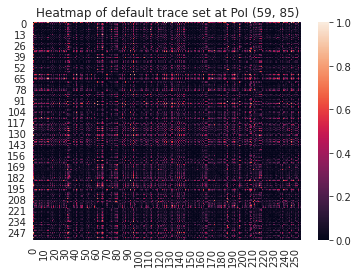

In [102]:
def get_heat_moment(heatmap, moment):
    return np.moveaxis(heatmap, 2, 0)[moment]

def plot_heatmap(heatmap, title):
    mean = get_heat_moment(heatmap, 0)
    mean_norm = mean / mean.max()
    sns.heatmap(data=mean_norm).set(title=title)

plot_heatmap(Heat.default, f"Heatmap of default trace set at PoI {POI}")

In [103]:
def get_max_index(heatmap, moment=0):
    heat_moment = get_heat_moment(heatmap, moment)
    return np.unravel_index(heat_moment.argmax(), heat_moment.shape)

get_max_index(Heat.default)

(0, 208)

## Problem statement

1. There is a first-order moment leakage visible in the standard ASCAD random-keys database.
2. This leakage is not visible in the masked-key and shuffled variants of this database.
3. The performance in terms of TP/FP rate is better for the masked-key and shuffled variants than it is for the
standard database.
4. It does not matter where the Point of Interest is located, while I would suspect that the performance varies for the
location of the PoI and that performance would be better in areas with a high moment difference.

#### Possible solutions (in order of likelihood):
1. There is a bug in the TVLA method.
2. There is a bug in the T-Test.
3. There is something fundamentally flawed with my understanding of the ASCAD database.

### Moment differences for each dataset.

The moment difference calculated as follows:
- Take keys $k_a$ and $k_b$, and their mean (first-order statistical moment) $\mu_a$ and $\mu_b$ per sample point.
- The euclidean distance between means from equal key $\eta = $ dist($\mu_{a}, \mu_b$) where $a = b$
- The euclidean distance between means from different key $\delta = $ dist($\mu_{a}, \mu_b$) where $a \neq b$
- Then the moment difference is $\eta - \delta$.

A positive moment difference reflects larger differences between equal keys and lower differences between different
keys, possibly indicating a leakage in this order of statistical moment.

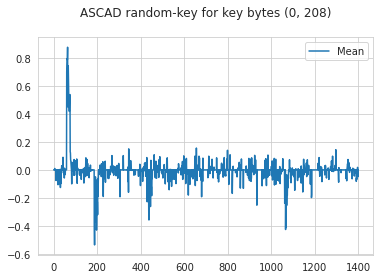

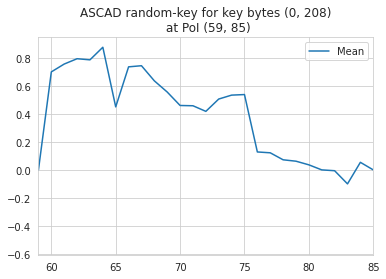

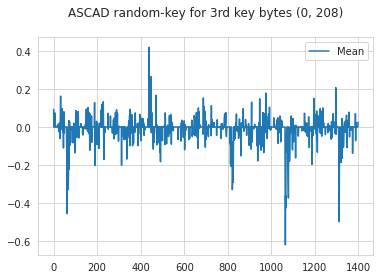

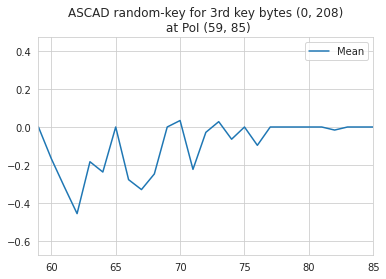

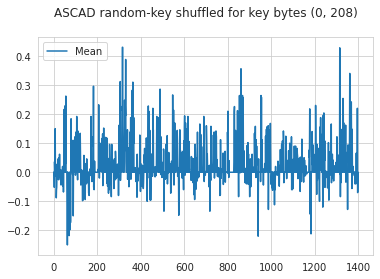

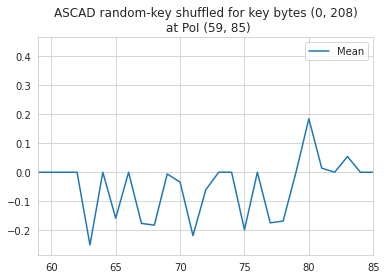

In [104]:
plot_highest_diff(mv_default, Heat.default, f"ASCAD random-key for key bytes {get_max_index(Heat.default)}\n")
plot_highest_diff(mv_masked, Heat.masked, f"ASCAD random-key for 3rd key bytes {get_max_index(Heat.masked)}\n")
plot_highest_diff(mv_random, Heat.random, f"ASCAD random-key shuffled for key bytes {get_max_index(Heat.masked)}\n")

In [105]:
def tables_at_poi(ctables, poi):
    """
    Loading ctables for each key into memory uses ~16GiB of mem
    """
    res = {}
    for k, key in tqdm(enumerate(ctables), total=len(ctables)):
        res[k] = {}
        for c, cat in enumerate(ctables[key]):
            res[k][c] = {}

            res[k][c] = np.zeros((len(ctables[key][cat]), poi[1] - poi[0], ctables[key][cat]["slice_0"].shape[1]), dtype=int)
            for s, slc in enumerate(ctables[key][cat]):
                res[k][c][s] = np.array(ctables[key][cat][slc][poi[0]:poi[1]])
    return res

tap_default = tables_at_poi(ct_default, POI)
tap_masked = tables_at_poi(ct_mask, POI)
tap_random = tables_at_poi(ct_random, POI)

# TODO tap to tvla for chi2

100%|██████████| 256/256 [00:00<00:00, 500.51it/s]


<AxesSubplot:>

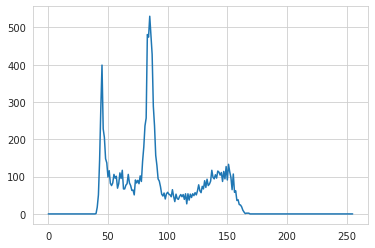

In [106]:
sns.lineplot(data=tap_default[0][0][0][0:50].sum(axis=0))

In [107]:
PV_TVLA = .95
PV_CHI2 = .99

class TTest(Tvla):
    default = cache.np(f"tvla_default_{int(PV_TVLA*100)}")
    masked = cache.np(f"tvla_masked_{int(PV_TVLA*100)}")
    random = cache.np(f"tvla_random_{int(PV_TVLA*100)}")

class Chi2(Tvla):
    default = cache.np(f"chi2_default_{int(PV_CHI2*100)}")
    masked = cache.np(f"chi2_masked_{int(PV_CHI2*100)}")
    random = cache.np(f"chi2_random_{int(PV_CHI2*100)}")

In [108]:
def analyse_tvla(tres: Tvla, heat: Tvla):
    for a in get_custom_attributes(Tvla):
        sums = np.zeros(7)
        total = 0

        result = getattr(tres, a)
        heatmap = getattr(heat, a)

        for k1, key_1 in enumerate(result):
            for k2, key_2 in enumerate(key_1):
                h = heatmap[k1][k2][0]
                l, r = key_2

                tp = l * (not r)
                fp = r * (not l)
                tph = h * tp
                fph = h * fp

                sums += np.array([*key_2, tp, fp, tph, fph, h])
                total += 1

        total = len(result) ** 2

        title = f" TVLA for {a} keys "
        print(f"\n{'=' * len(title)}")
        print(title)
        print(f"{'=' * len(title)}\n")

        print(f"For a total of {total} key combinations: \n")

        print(f"Left fails  {int(sums[0])} times.")
        print(f"Right fails {int(sums[1])} times. \n")

        print(f"True positives:  {int(sums[2])}")
        print(f"False positives: {int(sums[3])} \n")

        print(f"Average mean diff: {sums[6] / total:.4f}")
        print(f"Average mean diff for True positives:  {sums[4] / sums[0]:.4f}")
        print(f"Average mean diff for False positives: {sums[5] / (total - sums[0]):.4f} \n")

## $t$-test analysis on ASCAD

In [109]:
analyse_tvla(TTest, Heat)


 TVLA for default keys 

For a total of 65536 key combinations: 

Left fails  768 times.
Right fails 1170 times. 

True positives:  754
False positives: 1156 

Average mean diff: 0.0406
Average mean diff for True positives:  0.0517
Average mean diff for False positives: 0.0006 


 TVLA for masked keys 

For a total of 65536 key combinations: 

Left fails  1024 times.
Right fails 1217 times. 

True positives:  1002
False positives: 1195 

Average mean diff: 0.0406
Average mean diff for True positives:  0.0224
Average mean diff for False positives: 0.0008 


 TVLA for random keys 

For a total of 65536 key combinations: 

Left fails  768 times.
Right fails 1167 times. 

True positives:  748
False positives: 1147 

Average mean diff: 0.0406
Average mean diff for True positives:  0.0248
Average mean diff for False positives: 0.0007 



## $\chi^2$-test analysis on ASCAD

In [110]:
analyse_tvla(Chi2, Heat)


 TVLA for default keys 

For a total of 65536 key combinations: 

Left fails  43008 times.
Right fails 41859 times. 

True positives:  14786
False positives: 13637 

Average mean diff: 0.0406
Average mean diff for True positives:  0.0133
Average mean diff for False positives: 0.0244 


 TVLA for masked keys 

For a total of 65536 key combinations: 

Left fails  39680 times.
Right fails 41313 times. 

True positives:  13719
False positives: 15352 

Average mean diff: 0.0406
Average mean diff for True positives:  0.0143
Average mean diff for False positives: 0.0238 


 TVLA for random keys 

For a total of 65536 key combinations: 

Left fails  40192 times.
Right fails 40983 times. 

True positives:  13858
False positives: 14649 

Average mean diff: 0.0406
Average mean diff for True positives:  0.0136
Average mean diff for False positives: 0.0234 



## Next step

Use mean difference in TVLA evaluation.

TODO heat:
- Use mean and variance from old PoI finder for quick heatmap generation.
- Generate a heatmap for every sliding window step
- Generate TVLA results by using a sliding window